**Chapter 16 – Natural Language Processing with RNNs and Attention**

_This notebook contains all the sample code in chapter 16._

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/ageron/handson-ml2/blob/master/16_nlp_with_rnns_and_attention.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the
figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated, so we
strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20 and TensorFlow ≥2.0.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    !pip install -q -U tensorflow-addons
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
tf.config.experimental.set_memory_growth(tf.config.experimental.list_physical_devices('GPU')[0], True)

from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "nlp"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Char-RNN

## Splitting a sequence into batches of shuffled windows

For example, let's split the sequence 0 to 14 into windows of length 5, each shifted by 2 (e.g.,`[0, 1, 2, 3, 4]`,
`[2, 3, 4, 5, 6]`, etc.), then shuffle them, and split them into inputs (the first 4 steps) and targets (the
last 4 steps) (e.g., `[2, 3, 4, 5, 6]` would be split into `[[2, 3, 4, 5], [3, 4, 5, 6]]`), then create
batches of 3 such input/target pairs:

In [2]:
np.random.seed(42)
tf.random.set_seed(42)

n_steps = 5
dataset = tf.data.Dataset.from_tensor_slices(tf.range(15))
dataset = dataset.window(n_steps, shift=2, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(n_steps))
dataset = dataset.shuffle(10).map(lambda window: (window[:-1], window[1:]))
dataset = dataset.batch(3).prefetch(1)
for index, (X_batch, Y_batch) in enumerate(dataset):
    print("_" * 20, "Batch", index, "\nX_batch")
    print(X_batch.numpy())
    print("=" * 5, "\nY_batch")
    print(Y_batch.numpy())

____________________ Batch 0 
X_batch
[[6 7 8 9]
 [2 3 4 5]
 [4 5 6 7]]
===== 
Y_batch
[[ 7  8  9 10]
 [ 3  4  5  6]
 [ 5  6  7  8]]
____________________ Batch 1 
X_batch
[[ 0  1  2  3]
 [ 8  9 10 11]
 [10 11 12 13]]
===== 
Y_batch
[[ 1  2  3  4]
 [ 9 10 11 12]
 [11 12 13 14]]


## Loading the Data and Preparing the Dataset

In [3]:
shakespeare_url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
filepath = keras.utils.get_file("shakespeare.txt", shakespeare_url)
with open(filepath) as f:
    shakespeare_text = f.read()

In [4]:
print(shakespeare_text[:148])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?



In [5]:
"".join(sorted(set(shakespeare_text.lower())))

"\n !$&',-.3:;?abcdefghijklmnopqrstuvwxyz"

In [6]:
tokenizer = keras.preprocessing.text.Tokenizer(char_level=True)
tokenizer.fit_on_texts(shakespeare_text)

In [7]:
tokenizer.texts_to_sequences(["First"])

[[20, 6, 9, 8, 3]]

In [8]:
tokenizer.sequences_to_texts([[20, 6, 9, 8, 3]])

['f i r s t']

In [9]:
max_id = len(tokenizer.word_index) # number of distinct characters
dataset_size = tokenizer.document_count # total number of characters

print(max_id, dataset_size)

39 1115394


In [10]:
[encoded] = np.array(tokenizer.texts_to_sequences([shakespeare_text])) - 1
train_size = dataset_size * 90 // 100
dataset = tf.data.Dataset.from_tensor_slices(encoded[:train_size])

In [11]:
n_steps = 100
window_length = n_steps + 1 # target = input shifted 1 character ahead
dataset = dataset.repeat().window(window_length, shift=1, drop_remainder=True)

In [12]:
dataset = dataset.flat_map(lambda window: window.batch(window_length))

In [13]:
np.random.seed(42)
tf.random.set_seed(42)

In [14]:
batch_size = 4096
dataset = dataset.shuffle(10000).batch(batch_size)
dataset = dataset.map(lambda windows: (windows[:, :-1], windows[:, 1:]))


In [15]:
dataset = dataset.map(
    lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=max_id), Y_batch))

In [16]:
dataset = dataset.prefetch(1)

In [17]:
for X_batch, Y_batch in dataset.take(1):
    print(X_batch.shape, Y_batch.shape)

(4096, 100, 39) (4096, 100)


## Creating and Training the Model

In [18]:
## Recurrent Dropout is not implemented in Nvidia's cuDNN kernel
## https://github.com/tensorflow/tensorflow/issues/40944

model = keras.models.Sequential([
    keras.layers.GRU(128, return_sequences=True, input_shape=[None, max_id],
                     dropout=0.2, recurrent_dropout=0),
    keras.layers.GRU(128, return_sequences=True,
                     dropout=0.2, recurrent_dropout=0),
    keras.layers.TimeDistributed(keras.layers.Dense(max_id,
                                                    activation="softmax"))
])

model.compile(loss="sparse_categorical_crossentropy", optimizer="adam")

try:
    model = tf.keras.models.load_model('shakespeare_text.h5')
except:
    history = model.fit(dataset, steps_per_epoch=train_size // batch_size, epochs=10)
    model.save('shakespeare_text.h5')

# finally:
#     if not model:



## Using the Model to Generate Text

In [19]:
def preprocess(texts):
    X = np.array(tokenizer.texts_to_sequences(texts)) - 1
    print(X)
    return tf.one_hot(X, max_id)

In [20]:
X_new = preprocess(["How are yo"])
Y_pred = model.predict_classes(X_new)
tokenizer.sequences_to_texts(Y_pred + 1)[0][-1] # 1st sentence, last char

[[ 6  3 16  0  4  8  1  0 15  3]]
Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


'u'

In [21]:
tf.random.set_seed(42)

tf.random.categorical([[tf.math.log(0.5), tf.math.log(0.4), tf.math.log(0.1)]], num_samples=40).numpy()

array([[0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0,
        2, 0, 0, 1, 1, 1, 0, 0, 1, 2, 0, 0, 1, 1, 0, 0, 0, 0]])

In [22]:
def next_char(text, temperature=1):
    X_new = preprocess([text])
    y_proba = model.predict(X_new)[0, -1:, :]
    rescaled_logits = tf.math.log(y_proba) / temperature
    char_id = tf.random.categorical(rescaled_logits, num_samples=1) + 1
    return tokenizer.sequences_to_texts(char_id.numpy())[0]

In [23]:
tf.random.set_seed(42)

next_char("How are yo", temperature=1)

[[ 6  3 16  0  4  8  1  0 15  3]]


'u'

In [24]:
def complete_text(text, n_chars=50, temperature=1):
    for _ in range(n_chars):
        text += next_char(text, temperature)
    return text

In [25]:
tf.random.set_seed(42)

print(complete_text("t", temperature=0.2))

[[2]]
[[2 6]]
[[2 6 1]]
[[2 6 1 0]]
[[2 6 1 0 7]]
[[2 6 1 0 7 1]]
[[2 6 1 0 7 1 9]]
[[2 6 1 0 7 1 9 2]]
[[2 6 1 0 7 1 9 2 1]]
[[2 6 1 0 7 1 9 2 1 8]]
[[2 6 1 0 7 1 9 2 1 8 0]]
[[2 6 1 0 7 1 9 2 1 8 0 2]]
[[2 6 1 0 7 1 9 2 1 8 0 2 6]]
[[2 6 1 0 7 1 9 2 1 8 0 2 6 4]]
[[2 6 1 0 7 1 9 2 1 8 0 2 6 4 2]]
[[2 6 1 0 7 1 9 2 1 8 0 2 6 4 2 0]]
[[2 6 1 0 7 1 9 2 1 8 0 2 6 4 2 0 5]]
[[2 6 1 0 7 1 9 2 1 8 0 2 6 4 2 0 5 0]]
[[ 2  6  1  0  7  1  9  2  1  8  0  2  6  4  2  0  5  0 16]]
[[ 2  6  1  0  7  1  9  2  1  8  0  2  6  4  2  0  5  0 16  5]]
[[ 2  6  1  0  7  1  9  2  1  8  0  2  6  4  2  0  5  0 16  5 11]]
[[ 2  6  1  0  7  1  9  2  1  8  0  2  6  4  2  0  5  0 16  5 11 11]]
[[ 2  6  1  0  7  1  9  2  1  8  0  2  6  4  2  0  5  0 16  5 11 11  0]]
[[ 2  6  1  0  7  1  9  2  1  8  0  2  6  4  2  0  5  0 16  5 11 11  0  9]]
[[ 2  6  1  0  7  1  9  2  1  8  0  2  6  4  2  0  5  0 16  5 11 11  0  9
   3]]
[[ 2  6  1  0  7  1  9  2  1  8  0  2  6  4  2  0  5  0 16  5 11 11  0  9
   3  2]]
[[ 2  6  1

In [26]:
print(complete_text("t", temperature=1))

[[2]]
[[2 3]]
[[ 2  3 24]]
[[ 2  3 24  1]]
[[ 2  3 24  1  0]]
[[ 2  3 24  1  0  3]]
[[ 2  3 24  1  0  3 19]]
[[ 2  3 24  1  0  3 19  0]]
[[ 2  3 24  1  0  3 19  0  4]]
[[ 2  3 24  1  0  3 19  0  4 12]]
[[ 2  3 24  1  0  3 19  0  4 12 14]]
[[ 2  3 24  1  0  3 19  0  4 12 14  5]]
[[ 2  3 24  1  0  3 19  0  4 12 14  5  7]]
[[ 2  3 24  1  0  3 19  0  4 12 14  5  7  4]]
[[ 2  3 24  1  0  3 19  0  4 12 14  5  7  4  8]]
[[ 2  3 24  1  0  3 19  0  4 12 14  5  7  4  8  2]]
[[ 2  3 24  1  0  3 19  0  4 12 14  5  7  4  8  2 26]]
[[ 2  3 24  1  0  3 19  0  4 12 14  5  7  4  8  2 26 10]]
[[ 2  3 24  1  0  3 19  0  4 12 14  5  7  4  8  2 26 10 10]]
[[ 2  3 24  1  0  3 19  0  4 12 14  5  7  4  8  2 26 10 10 18]]
[[ 2  3 24  1  0  3 19  0  4 12 14  5  7  4  8  2 26 10 10 18  3]]
[[ 2  3 24  1  0  3 19  0  4 12 14  5  7  4  8  2 26 10 10 18  3  8]]
[[ 2  3 24  1  0  3 19  0  4 12 14  5  7  4  8  2 26 10 10 18  3  8  5]]
[[ 2  3 24  1  0  3 19  0  4 12 14  5  7  4  8  2 26 10 10 18  3  8  5  3]]
[[ 2  3

In [27]:
print(complete_text("t", temperature=2))

[[2]]
[[ 2 22]]
[[ 2 22  1]]
[[ 2 22  1  9]]
[[ 2 22  1  9 12]]
[[ 2 22  1  9 12  3]]
[[ 2 22  1  9 12  3 14]]
[[ 2 22  1  9 12  3 14  1]]
[[ 2 22  1  9 12  3 14  1 14]]
[[ 2 22  1  9 12  3 14  1 14  0]]
[[ 2 22  1  9 12  3 14  1 14  0 19]]
[[ 2 22  1  9 12  3 14  1 14  0 19  4]]
[[ 2 22  1  9 12  3 14  1 14  0 19  4 18]]
[[ 2 22  1  9 12  3 14  1 14  0 19  4 18  1]]
[[ 2 22  1  9 12  3 14  1 14  0 19  4 18  1 29]]
[[ 2 22  1  9 12  3 14  1 14  0 19  4 18  1 29  0]]
[[ 2 22  1  9 12  3 14  1 14  0 19  4 18  1 29  0  2]]
[[ 2 22  1  9 12  3 14  1 14  0 19  4 18  1 29  0  2  5]]
[[ 2 22  1  9 12  3 14  1 14  0 19  4 18  1 29  0  2  5 20]]
[[ 2 22  1  9 12  3 14  1 14  0 19  4 18  1 29  0  2  5 20  3]]
[[ 2 22  1  9 12  3 14  1 14  0 19  4 18  1 29  0  2  5 20  3 23]]
[[ 2 22  1  9 12  3 14  1 14  0 19  4 18  1 29  0  2  5 20  3 23 17]]
[[ 2 22  1  9 12  3 14  1 14  0 19  4 18  1 29  0  2  5 20  3 23 17  0]]
[[ 2 22  1  9 12  3 14  1 14  0 19  4 18  1 29  0  2  5 20  3 23 17  0  6]]
[[ 2 

## Stateful RNN

In [28]:
tf.random.set_seed(42)

In [29]:
dataset = tf.data.Dataset.from_tensor_slices(encoded[:train_size])
dataset = dataset.window(window_length, shift=n_steps, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(window_length))
dataset = dataset.repeat().batch(1)

for e in dataset:
    print(e)
    break

# list(dataset.as_numpy_iterator())

tf.Tensor(
[[19  5  8  7  2  0 18  5  2  5 35  1  9 23 10 21  1 19  3  8  1  0 16  1
   0 22  8  3 18  1  1 12  0  4  9 15  0 19 13  8  2  6  1  8 17  0  6  1
   4  8  0 14  1  0  7 22  1  4 24 26 10 10  4 11 11 23 10  7 22  1  4 24
  17  0  7 22  1  4 24 26 10 10 19  5  8  7  2  0 18  5  2  5 35  1  9 23
  10 15  3 13  0]], shape=(1, 101), dtype=int64)


In [30]:
dataset = dataset.map(lambda windows: (windows[:, :-1], windows[:, 1:]))
dataset = dataset.map(lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=max_id), Y_batch))
dataset = dataset.prefetch(1)


In [31]:
batch_size = 4096
encoded_parts = np.array_split(encoded[:train_size], batch_size)
datasets = []
for encoded_part in encoded_parts:
    dataset = tf.data.Dataset.from_tensor_slices(encoded_part)
    dataset = dataset.window(window_length, shift=n_steps, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_length))
    datasets.append(dataset)

dataset = tf.data.Dataset.zip(tuple(datasets)).map(lambda *windows: tf.stack(windows))
dataset = dataset.repeat().map(lambda windows: (windows[:, :-1], windows[:, 1:]))
dataset = dataset.map(
    lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=max_id), Y_batch))
dataset = dataset.prefetch(1)

In [32]:
model = keras.models.Sequential([
    keras.layers.GRU(128, return_sequences=True, stateful=True,
                     dropout=0.2, recurrent_dropout=0,          # recurrent_dropout: 0.2 -> 0
                     batch_input_shape=[batch_size, None, max_id]),
    keras.layers.GRU(128, return_sequences=True, stateful=True,
                     dropout=0.2, recurrent_dropout=0),         # recurrent_dropout: 0.2 -> 0
    keras.layers.TimeDistributed(keras.layers.Dense(max_id,
                                                    activation="softmax"))
])

In [33]:
class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

In [34]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam")
steps_per_epoch = train_size // batch_size // n_steps

history = model.fit(dataset,
                    steps_per_epoch=steps_per_epoch,
                    epochs=50,
                    callbacks=[ResetStatesCallback()])

Epoch 1/50
2/2 [==============================] - 0s 192ms/step - loss: 3.6592
Epoch 2/50
2/2 [==============================] - 1s 259ms/step - loss: 3.6274
Epoch 3/50
2/2 [==============================] - 1s 341ms/step - loss: 3.5871
Epoch 4/50
2/2 [==============================] - 1s 255ms/step - loss: 3.5261
Epoch 5/50
2/2 [==============================] - 1s 266ms/step - loss: 3.4283
Epoch 6/50
2/2 [=========

To use the model with different batch sizes, we need to create a stateless copy. We can get rid of dropout since
it is only used during training:

In [35]:
stateless_model = keras.models.Sequential([
    keras.layers.GRU(128, return_sequences=True, input_shape=[None, max_id]),
    keras.layers.GRU(128, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(max_id,
                                                    activation="softmax"))
])

To set the weights, we first need to build the model (so the weights get created):

In [36]:
stateless_model.build(tf.TensorShape([None, None, max_id]))

In [37]:
stateless_model.set_weights(model.get_weights())
model = stateless_model

In [38]:
tf.random.set_seed(42)

print(complete_text("t"))

[[2]]
[[ 2 30]]
[[ 2 30  6]]
[[ 2 30  6 17]]
[[ 2 30  6 17  0]]
[[ 2 30  6 17  0  3]]
[[ 2 30  6 17  0  3 13]]
[[ 2 30  6 17  0  3 13 12]]
[[ 2 30  6 17  0  3 13 12 17]]
[[ 2 30  6 17  0  3 13 12 17 23]]
[[ 2 30  6 17  0  3 13 12 17 23 10]]
[[ 2 30  6 17  0  3 13 12 17 23 10  9]]
[[ 2 30  6 17  0  3 13 12 17 23 10  9  1]]
[[ 2 30  6 17  0  3 13 12 17 23 10  9  1  0]]
[[ 2 30  6 17  0  3 13 12 17 23 10  9  1  0  2]]
[[ 2 30  6 17  0  3 13 12 17 23 10  9  1  0  2 15]]
[[ 2 30  6 17  0  3 13 12 17 23 10  9  1  0  2 15  3]]
[[ 2 30  6 17  0  3 13 12 17 23 10  9  1  0  2 15  3  1]]
[[ 2 30  6 17  0  3 13 12 17 23 10  9  1  0  2 15  3  1  8]]
[[ 2 30  6 17  0  3 13 12 17 23 10  9  1  0  2 15  3  1  8  0]]
[[ 2 30  6 17  0  3 13 12 17 23 10  9  1  0  2 15  3  1  8  0  2]]
[[ 2 30  6 17  0  3 13 12 17 23 10  9  1  0  2 15  3  1  8  0  2  6]]
[[ 2 30  6 17  0  3 13 12 17 23 10  9  1  0  2 15  3  1  8  0  2  6  5]]
[[ 2 30  6 17  0  3 13 12 17 23 10  9  1  0  2 15  3  1  8  0  2  6  5  7]]
[[ 2 

# Sentiment Analysis

In [39]:
tf.random.set_seed(42)

You can load the IMDB dataset easily:

In [40]:
(X_train, y_test), (X_valid, y_test) = keras.datasets.imdb.load_data()

In [41]:
X_train[0][:10]

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65]

In [42]:
word_index = keras.datasets.imdb.get_word_index()
id_to_word = {id_ + 3: word for word, id_ in word_index.items()}
for id_, token in enumerate(("<pad>", "<sos>", "<unk>")):
    id_to_word[id_] = token

" ".join([id_to_word[id_] for id_ in X_train[0][:10]])

'<sos> this film was just brilliant casting location scenery story'

In [43]:
import tensorflow_datasets as tfds

datasets, info = tfds.load("imdb_reviews", as_supervised=True, with_info=True)

In [44]:
datasets.keys()

dict_keys(['test', 'train', 'unsupervised'])

In [45]:
train_size = info.splits["train"].num_examples
test_size = info.splits["test"].num_examples

In [46]:
train_size, test_size

(25000, 25000)

In [47]:
for X_batch, y_batch in datasets["train"].batch(2).take(1):
    for review, label in zip(X_batch.numpy(), y_batch.numpy()):
        print("Review:", review.decode("utf-8")[:200], "...")
        print("Label:", label, "= Positive" if label else "= Negative")
        print()

Review: This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting  ...
Label: 0 = Negative

Review: I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However  ...
Label: 0 = Negative



In [48]:
def preprocess(X_batch, y_batch):
    X_batch = tf.strings.substr(X_batch, 0, 300)
    X_batch = tf.strings.regex_replace(X_batch, rb"<br\s*/?>", b" ")
    X_batch = tf.strings.regex_replace(X_batch, b"[^a-zA-Z']", b" ")
    X_batch = tf.strings.split(X_batch)
    return X_batch.to_tensor(default_value=b"<pad>"), y_batch

In [49]:
preprocess(X_batch, y_batch)

(<tf.Tensor: shape=(2, 53), dtype=string, numpy=
 array([[b'This', b'was', b'an', b'absolutely', b'terrible', b'movie',
         b"Don't", b'be', b'lured', b'in', b'by', b'Christopher',
         b'Walken', b'or', b'Michael', b'Ironside', b'Both', b'are',
         b'great', b'actors', b'but', b'this', b'must', b'simply', b'be',
         b'their', b'worst', b'role', b'in', b'history', b'Even',
         b'their', b'great', b'acting', b'could', b'not', b'redeem',
         b'this', b"movie's", b'ridiculous', b'storyline', b'This',
         b'movie', b'is', b'an', b'early', b'nineties', b'US',
         b'propaganda', b'pi', b'<pad>', b'<pad>', b'<pad>'],
        [b'I', b'have', b'been', b'known', b'to', b'fall', b'asleep',
         b'during', b'films', b'but', b'this', b'is', b'usually', b'due',
         b'to', b'a', b'combination', b'of', b'things', b'including',
         b'really', b'tired', b'being', b'warm', b'and', b'comfortable',
         b'on', b'the', b'sette', b'and', b'having', b'j

In [50]:
from collections import Counter

vocabulary = Counter()
for X_batch, y_batch in datasets["train"].batch(32).map(preprocess):
    for review in X_batch:
        vocabulary.update(list(review.numpy()))

In [51]:
vocabulary.most_common()[:3]

[(b'<pad>', 214309), (b'the', 61137), (b'a', 38564)]

In [52]:
len(vocabulary)

53893

In [53]:
vocab_size = 10000
truncated_vocabulary = [
    word for word, count in vocabulary.most_common()[:vocab_size]]

In [54]:
word_to_id = {word: index for index, word in enumerate(truncated_vocabulary)}
for word in b"This movie was faaaaaantastic".split():
    print(word_to_id.get(word) or vocab_size)

22
12
11
10000


In [55]:
words = tf.constant(truncated_vocabulary)
word_ids = tf.range(len(truncated_vocabulary), dtype=tf.int64)
vocab_init = tf.lookup.KeyValueTensorInitializer(words, word_ids)
num_oov_buckets = 1000
table = tf.lookup.StaticVocabularyTable(vocab_init, num_oov_buckets)

In [56]:
table.lookup(tf.constant([b"This movie was faaaaaantastic".split()]))

<tf.Tensor: shape=(1, 4), dtype=int64, numpy=array([[   22,    12,    11, 10053]])>

In [57]:
def encode_words(X_batch, y_batch):
    return table.lookup(X_batch), y_batch

train_set = datasets["train"].repeat().batch(32).map(preprocess)
train_set = train_set.map(encode_words).prefetch(1)

In [58]:
for X_batch, y_batch in train_set.take(1):
    print(X_batch)
    print(y_batch)

tf.Tensor(
[[  22   11   28 ...    0    0    0]
 [   6   21   70 ...    0    0    0]
 [4099 6881    1 ...    0    0    0]
 ...
 [  22   12  118 ...  331 1047    0]
 [1757 4101  451 ...    0    0    0]
 [3365 4392    6 ...    0    0    0]], shape=(32, 60), dtype=int64)
tf.Tensor([0 0 0 1 1 1 0 0 0 0 0 1 1 0 1 0 1 1 1 0 1 1 1 1 1 0 0 0 1 0 0 0], shape=(32,), dtype=int64)


In [59]:
embed_size = 128
model = keras.models.Sequential([
    keras.layers.Embedding(vocab_size + num_oov_buckets, embed_size,
                           mask_zero=True, # not shown in the book
                           input_shape=[None]),
    keras.layers.GRU(128, return_sequences=True),
    keras.layers.GRU(128),
    keras.layers.Dense(1, activation="sigmoid")
])
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(train_set, steps_per_epoch=train_size // 32, epochs=5)

Epoch 1/5
781/781 [==============================] - 16s 21ms/step - loss: 0.5305 - accuracy: 0.7281

Or using manual masking:

In [60]:
K = keras.backend
embed_size = 128
inputs = keras.layers.Input(shape=[None])
mask = keras.layers.Lambda(lambda inputs: K.not_equal(inputs, 0))(inputs)
z = keras.layers.Embedding(vocab_size + num_oov_buckets, embed_size)(inputs)
z = keras.layers.GRU(128, return_sequences=True)(z, mask=mask)
z = keras.layers.GRU(128)(z, mask=mask)

outputs = keras.layers.Dense(1, activation="sigmoid")(z)
model = keras.models.Model(inputs=[inputs], outputs=[outputs])
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(train_set, steps_per_epoch=train_size // 32, epochs=5)

Epoch 1/5
781/781 [==============================] - 16s 21ms/step - loss: 0.5426 - accuracy: 0.7155

## Reusing Pretrained Embeddings

In [61]:
tf.random.set_seed(42)

In [62]:
TFHUB_CACHE_DIR = os.path.join(os.curdir, "my_tfhub_cache")
os.environ["TFHUB_CACHE_DIR"] = TFHUB_CACHE_DIR

In [63]:
# pip install tensorflow-hub

import tensorflow_hub as hub

model = keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1",
                   dtype=tf.string, input_shape=[], output_shape=[50]),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid")
])
model.compile(loss="binary_crossentropy", optimizer="adam",
              metrics=["accuracy"])

In [64]:
for dirpath, dirnames, filenames in os.walk(TFHUB_CACHE_DIR):
    for filename in filenames:
        print(os.path.join(dirpath, filename))

./my_tfhub_cache/82c4aaf4250ffb09088bd48368ee7fd00e5464fe.descriptor.txt
./my_tfhub_cache/82c4aaf4250ffb09088bd48368ee7fd00e5464fe/saved_model.pb
./my_tfhub_cache/82c4aaf4250ffb09088bd48368ee7fd00e5464fe/variables/variables.index
./my_tfhub_cache/82c4aaf4250ffb09088bd48368ee7fd00e5464fe/variables/variables.data-00000-of-00001
./my_tfhub_cache/82c4aaf4250ffb09088bd48368ee7fd00e5464fe/assets/tokens.txt


In [65]:
import tensorflow_datasets as tfds

datasets, info = tfds.load("imdb_reviews", as_supervised=True, with_info=True)
train_size = info.splits["train"].num_examples
batch_size = 32
train_set = datasets["train"].repeat().batch(batch_size).prefetch(1)
history = model.fit(train_set, steps_per_epoch=train_size // batch_size, epochs=5)

Epoch 1/5
781/781 [==============================] - 2s 3ms/step - loss: 0.5460 - accuracy: 0.7267

## Automatic Translation

In [66]:
tf.random.set_seed(42)

In [67]:
vocab_size = 100
embed_size = 10

In [68]:
import tensorflow_addons as tfa

encoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
decoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
sequence_lengths = keras.layers.Input(shape=[], dtype=np.int32)

embeddings = keras.layers.Embedding(vocab_size, embed_size)
encoder_embeddings = embeddings(encoder_inputs)
decoder_embeddings = embeddings(decoder_inputs)

encoder = keras.layers.LSTM(512, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_embeddings)
encoder_state = [state_h, state_c]

sampler = tfa.seq2seq.sampler.TrainingSampler()

decoder_cell = keras.layers.LSTMCell(512)
output_layer = keras.layers.Dense(vocab_size)

decoder = tfa.seq2seq.basic_decoder.BasicDecoder(decoder_cell, sampler,
                                                 output_layer=output_layer)

final_outputs, final_state, final_sequence_lengths = decoder(
    decoder_embeddings, initial_state=encoder_state,
    sequence_length=sequence_lengths)
Y_proba = tf.nn.softmax(final_outputs.rnn_output)

model = keras.models.Model(
    inputs=[encoder_inputs, decoder_inputs, sequence_lengths],
    outputs=[Y_proba])

In [69]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam")

In [70]:
X = np.random.randint(100, size=10*1000).reshape(1000, 10)
Y = np.random.randint(100, size=15*1000).reshape(1000, 15)

X_decoder = np.c_[np.zeros((1000, 1)), Y[:, :-1]]
seq_lengths = np.full([1000], 15)

history = model.fit([X, X_decoder, seq_lengths], Y, epochs=2)

Epoch 1/2
32/32 [==============================] - 0s 14ms/step - loss: 4.6053
Epoch 2/2
32/32 [==============================] - 0s 14ms/step - loss: 4.6029

### Bidirectional Recurrent Layers

In [71]:
model = keras.models.Sequential([
    keras.layers.GRU(10, return_sequences=True, input_shape=[None, 10]),
    keras.layers.Bidirectional(keras.layers.GRU(10, return_sequences=True))
])

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_10 (GRU)                 (None, None, 10)          660       
_________________________________________________________________
bidirectional (Bidirectional (None, None, 20)          1320      
Total params: 1,980
Trainable params: 1,980
Non-trainable params: 0
_________________________________________________________________


### Positional Encoding

In [72]:
class PositionalEncoding(keras.layers.Layer):
    def __init__(self, max_steps, max_dims, dtype=tf.float32, **kwargs):
        super().__init__(dtype=dtype, **kwargs)
        if max_dims % 2 == 1: max_dims += 1 # max_dims must be even
        p, i = np.meshgrid(np.arange(max_steps), np.arange(max_dims // 2))
        pos_emb = np.empty((1, max_steps, max_dims))
        pos_emb[0, :, ::2] = np.sin(p / 10000**(2 * i / max_dims)).T
        pos_emb[0, :, 1::2] = np.cos(p / 10000**(2 * i / max_dims)).T
        self.positional_embedding = tf.constant(pos_emb.astype(self.dtype))

    def call(self, inputs):
        shape = tf.shape(inputs)
        return inputs + self.positional_embedding[:, :shape[-2], :shape[-1]]

In [73]:
max_steps = 201
max_dims = 512
pos_emb = PositionalEncoding(max_steps, max_dims)
PE = pos_emb(np.zeros((1, max_steps, max_dims), np.float32))[0].numpy()

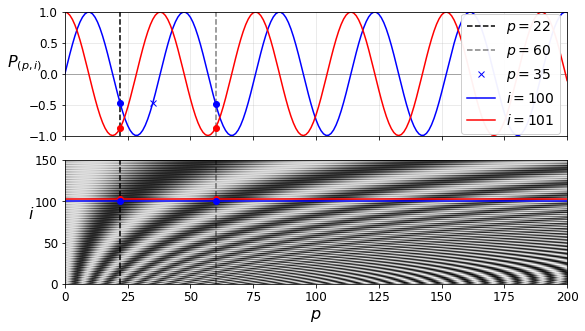

In [74]:
i1, i2, crop_i = 100, 101, 150
p1, p2, p3 = 22, 60, 35
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(9, 5))
ax1.plot([p1, p1], [-1, 1], "k--", label="$p = {}$".format(p1))
ax1.plot([p2, p2], [-1, 1], "k--", label="$p = {}$".format(p2), alpha=0.5)
ax1.plot(p3, PE[p3, i1], "bx", label="$p = {}$".format(p3))
ax1.plot(PE[:, i1], "b-", label="$i = {}$".format(i1))
ax1.plot(PE[:, i2], "r-", label="$i = {}$".format(i2))
ax1.plot([p1, p2], [PE[p1, i1], PE[p2, i1]], "bo")
ax1.plot([p1, p2], [PE[p1, i2], PE[p2, i2]], "ro")
ax1.legend(loc="center right", fontsize=14, framealpha=0.95)
ax1.set_ylabel("$P_{(p,i)}$", rotation=0, fontsize=16)
ax1.grid(True, alpha=0.3)
ax1.hlines(0, 0, max_steps - 1, color="k", linewidth=1, alpha=0.3)
ax1.axis([0, max_steps - 1, -1, 1])

ax2.imshow(PE.T[:crop_i], cmap="gray", interpolation="bilinear", aspect="auto")
ax2.hlines(i1, 0, max_steps - 1, color="b")
cheat = 2 # need to raise the red line a bit, or else it hides the blue one
ax2.hlines(i2+cheat, 0, max_steps - 1, color="r")
ax2.plot([p1, p1], [0, crop_i], "k--")
ax2.plot([p2, p2], [0, crop_i], "k--", alpha=0.5)
ax2.plot([p1, p2], [i2+cheat, i2+cheat], "ro")
ax2.plot([p1, p2], [i1, i1], "bo")
ax2.axis([0, max_steps - 1, 0, crop_i])
ax2.set_xlabel("$p$", fontsize=16)
ax2.set_ylabel("$i$", rotation=0, fontsize=16)
plt.savefig("positional_embedding_plot")
plt.show()

In [75]:
embed_size = 512; max_steps = 500; vocab_size = 10000
encoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
decoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
embeddings = keras.layers.Embedding(vocab_size, embed_size)
encoder_embeddings = embeddings(encoder_inputs)
decoder_embeddings = embeddings(decoder_inputs)
positional_encoding = PositionalEncoding(max_steps, max_dims=embed_size)
encoder_in = positional_encoding(encoder_embeddings)
decoder_in = positional_encoding(decoder_embeddings)

Here is a (very) simplified Transformer (the actual architecture has skip connections, layer norm, dense nets,
and most importantly it uses Multi-Head Attention instead of regular Attention):

In [76]:
Z = encoder_in
for N in range(6):
    Z = keras.layers.Attention(use_scale=True)([Z, Z])

encoder_outputs = Z
Z = decoder_in

for N in range(6):
    Z = keras.layers.Attention(use_scale=True, causal=True)([Z, Z])
    Z = keras.layers.Attention(use_scale=True)([Z, encoder_outputs])

outputs = keras.layers.TimeDistributed(
    keras.layers.Dense(vocab_size, activation="softmax"))(Z)

Here's a basic implementation of the `MultiHeadAttention` layer. One will likely be added to `keras.layers` in
the near future. Note that `Conv1D` layers with `kernel_size=1` (and the default `padding="valid"` and `strides=1`)
is equivalent to a `TimeDistributed(Dense(...))` layer.

In [77]:
K = keras.backend

class MultiHeadAttention(keras.layers.Layer):
    def __init__(self, n_heads, causal=False, use_scale=False, **kwargs):
        self.n_heads = n_heads
        self.causal = causal
        self.use_scale = use_scale
        super().__init__(**kwargs)
    def build(self, batch_input_shape):
        self.dims = batch_input_shape[0][-1]
        self.q_dims, self.v_dims, self.k_dims = [self.dims // self.n_heads] * 3 # could be hyperparameters instead
        self.q_linear = keras.layers.Conv1D(self.n_heads * self.q_dims, kernel_size=1, use_bias=False)
        self.v_linear = keras.layers.Conv1D(self.n_heads * self.v_dims, kernel_size=1, use_bias=False)
        self.k_linear = keras.layers.Conv1D(self.n_heads * self.k_dims, kernel_size=1, use_bias=False)
        self.attention = keras.layers.Attention(causal=self.causal, use_scale=self.use_scale)
        self.out_linear = keras.layers.Conv1D(self.dims, kernel_size=1, use_bias=False)
        super().build(batch_input_shape)
    def _multi_head_linear(self, inputs, linear):
        shape = K.concatenate([K.shape(inputs)[:-1], [self.n_heads, -1]])
        projected = K.reshape(linear(inputs), shape)
        perm = K.permute_dimensions(projected, [0, 2, 1, 3])
        return K.reshape(perm, [shape[0] * self.n_heads, shape[1], -1])
    def call(self, inputs):
        q = inputs[0]
        v = inputs[1]
        k = inputs[2] if len(inputs) > 2 else v
        shape = K.shape(q)
        q_proj = self._multi_head_linear(q, self.q_linear)
        v_proj = self._multi_head_linear(v, self.v_linear)
        k_proj = self._multi_head_linear(k, self.k_linear)
        multi_attended = self.attention([q_proj, v_proj, k_proj])
        shape_attended = K.shape(multi_attended)
        reshaped_attended = K.reshape(multi_attended, [shape[0], self.n_heads, shape_attended[1], shape_attended[2]])
        perm = K.permute_dimensions(reshaped_attended, [0, 2, 1, 3])
        concat = K.reshape(perm, [shape[0], shape_attended[1], -1])
        return self.out_linear(concat)

In [78]:
Q = np.random.rand(2, 50, 512)
V = np.random.rand(2, 80, 512)
multi_attn = MultiHeadAttention(8)
multi_attn([Q, V]).shape


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



TensorShape([2, 50, 512])